# Step1_Dataset_Inspection_and_Preparation

Here are ALL the libraries you need to install once in your Python environment before running Step 1 (and the rest of the project).
Run these commands in your VS Code terminal (or Anaconda Prompt).

Step 1: Install Required Libraries
Bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
 (Use the above for CPU only. If you have GPU + CUDA, use the official command from pytorch.org instead)

pip install scikit-learn pandas numpy matplotlib seaborn pillow tqdm opencv-python
That’s it — these 8 packages cover everything for the entire project.

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

pip install scikit-learn pandas numpy matplotlib seaborn pillow tqdm opencv-python

In [1]:
# RUN THIS CELL FIRST to verify everything is installed correctly
import importlib

required_packages = {
    'torch': 'PyTorch',
    'torchvision': 'TorchVision',
    'sklearn': 'Scikit-learn',
    'pandas': 'Pandas',
    'numpy': 'NumPy',
    'matplotlib': 'Matplotlib',
    'seaborn': 'Seaborn',
    'PIL': 'Pillow',
    'cv2': 'OpenCV',
    'tqdm': 'tqdm'
}

missing = []
for module, name in required_packages.items():
    try:
        importlib.import_module(module)
        print(f"✓ {name} is installed")
    except ImportError:
        missing.append(name)
        print(f"✗ {name} is MISSING")

if missing:
    print(f"\nPlease install missing packages: {', '.join(missing)}")
else:
    print("\nAll required libraries are installed and ready!")
    print("You can now safely run Step 1 code!")

✓ PyTorch is installed
✓ TorchVision is installed
✓ Scikit-learn is installed
✓ Pandas is installed
✓ NumPy is installed
✓ Matplotlib is installed
✓ Seaborn is installed
✓ Pillow is installed
✓ OpenCV is installed
✓ tqdm is installed

All required libraries are installed and ready!
You can now safely run Step 1 code!


Step 1: Dataset Inspection and Preparation

# PART 1: Imports & Basic Settings

In [2]:
# ==================== PART 1: Imports & Settings ====================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import hashlib
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings('ignore')

# For nice plots
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Verify current directory has the folders
print("Current working directory:", os.getcwd())
print("Folders found:", [f for f in os.listdir('.') if os.path.isdir(f) and f in ['mri', 'ct', 'pet']])

Current working directory: c:\Users\vautr\Downloads\UK_pro_3
Folders found: ['ct', 'mri', 'pet']


In [ ]:
# QUICK FIX: Handle the 587 "unknown" tumors in MRI
import os
import shutil
from pathlib import Path

tumor_dir = Path('mri') / 'Tumor'
unknown_dir = tumor_dir / 'Unknown'

# Create Unknown folder
os.makedirs(unknown_dir, exist_ok=True)

moved_unknown = 0
for img_file in tumor_dir.iterdir():
    if (img_file.is_file() and 
        img_file.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'} and
        'tumor' in img_file.name.lower() and 
        img_file.parent == tumor_dir):  # Still in main Tumor folder
        
        shutil.move(str(img_file), str(unknown_dir / img_file.name))
        moved_unknown += 1

print(f"MRI UNKNOWN TUMORS MOVED: {moved_unknown}")
print("Now MRI structure:")
print("  Tumor/Glioma: ✓ labeled")
print("  Tumor/Meningioma: ✓ labeled") 
print("  Tumor/Pituitary: ✓ labeled")
print("  Tumor/Unknown: 587 generic tumors ✓ organized")

MRI UNKNOWN TUMORS MOVED: 587
Now MRI structure:
  Tumor/Glioma: ✓ labeled
  Tumor/Meningioma: ✓ labeled
  Tumor/Pituitary: ✓ labeled
  Tumor/Unknown: 587 generic tumors ✓ organized


In [4]:
# ONE-TIME FIX: Organize MRI and PET tumor images into proper subfolders
import os
import shutil
from pathlib import Path

def organize_tumor_folder(modality):
    tumor_dir = Path(modality) / "Tumor"
    if not tumor_dir.exists():
        print(f"{modality}/Tumor not found")
        return
    
    # Create subfolders if they don't exist
    for subtype in ['Glioma', 'Meningioma', 'Pituitary']:
        os.makedirs(tumor_dir / subtype, exist_ok=True)
    
    # Keyword mapping (case-insensitive)
    keyword_map = {
        'glioma': 'Glioma',
        'meningioma': 'Meningioma',
        'pituitary': 'Pituitary',
        'mening': 'Meningioma',      # common abbreviation
        'pit': 'Pituitary',          # short form
        'glio': 'Glioma'
    }
    
    moved = 0
    unmoved = []
    
    for img_file in tumor_dir.iterdir():
        if img_file.is_file() and img_file.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}:
            img_name = img_file.name.lower()
            
            # Skip if already in a subfolder (prevents double-moving)
            if img_file.parent != tumor_dir:
                continue
                
            matched = False
            for keyword, folder in keyword_map.items():
                if keyword in img_name:
                    dest = tumor_dir / folder / img_file.name
                    shutil.move(str(img_file), str(dest))
                    moved += 1
                    matched = True
                    break
            
            if not matched:
                unmoved.append(img_file.name)
    
    print(f"\n{modality.upper()} ORGANIZATION COMPLETE")
    print(f"   Images moved: {moved}")
    if unmoved:
        print(f"   Could not classify ({len(unmoved)}):")
        for f in unmoved[:10]:
            print(f"      → {f}")
        if len(unmoved) > 10:
            print(f"      ... and {len(unmoved)-10} more")
    else:
        print("   All images successfully classified!")

# RUN THIS FOR MRI AND PET ONLY
organize_tumor_folder('mri')
organize_tumor_folder('pet')

print("\nDone! Now all 3 modalities have the correct structure:")
print("   mri/Tumor/Glioma, Meningioma, Pituitary")
print("   ct/Tumor/  ← already good")
print("   pet/Tumor/Glioma, Meningioma, Pituitary")


MRI ORGANIZATION COMPLETE
   Images moved: 2413
   Could not classify (587):
      → tumor (1).jpeg
      → tumor (1).jpg
      → tumor (10).jpeg
      → tumor (10).jpg
      → tumor (100).jpg
      → tumor (101).jpg
      → tumor (102).jpg
      → tumor (103).jpg
      → tumor (104).jpg
      → tumor (105).jpg
      ... and 577 more

PET ORGANIZATION COMPLETE
   Images moved: 53
   All images successfully classified!

Done! Now all 3 modalities have the correct structure:
   mri/Tumor/Glioma, Meningioma, Pituitary
   ct/Tumor/  ← already good
   pet/Tumor/Glioma, Meningioma, Pituitary


# PART 2: Full Inspection Function (One modality at a time)


INSPECTING MRI DATASET
      Class  Count
     Glioma    672
 Meningioma   1112
  Pituitary    629
    Healthy   2000
Total Tumor   2413
Grand Total   4413


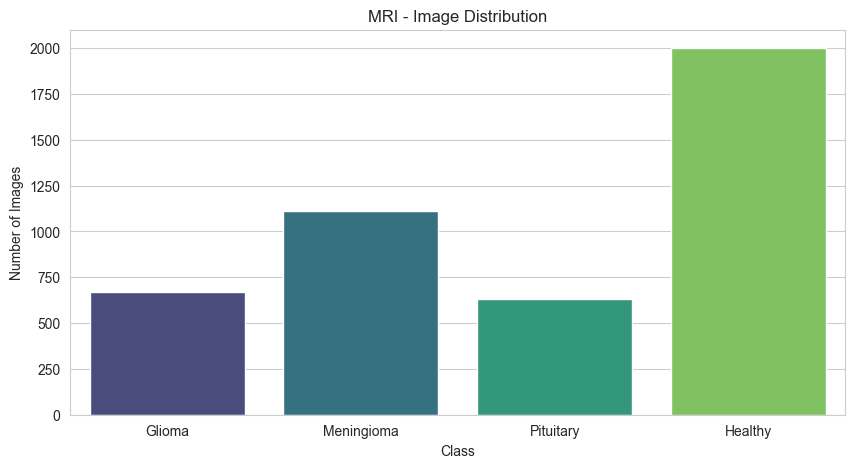

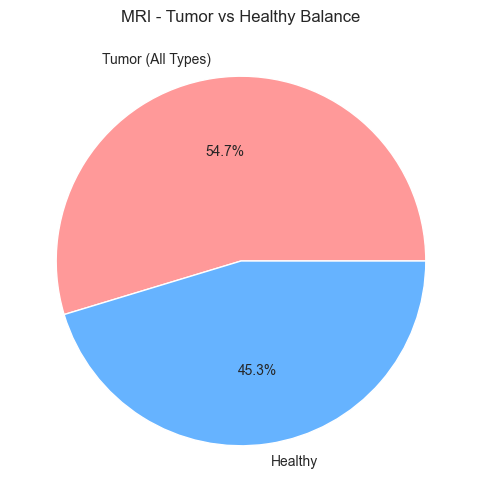


INSPECTING CT DATASET
      Class  Count
     Glioma     68
 Meningioma   2157
  Pituitary     93
    Healthy   2300
Total Tumor   2318
Grand Total   4618


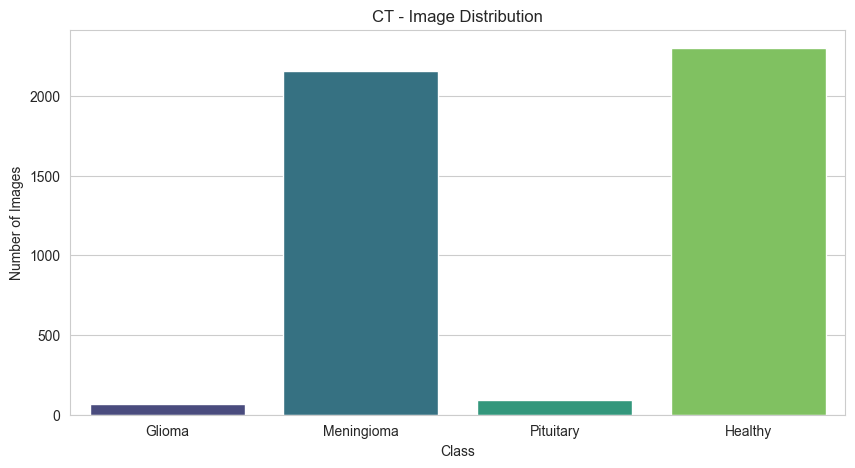

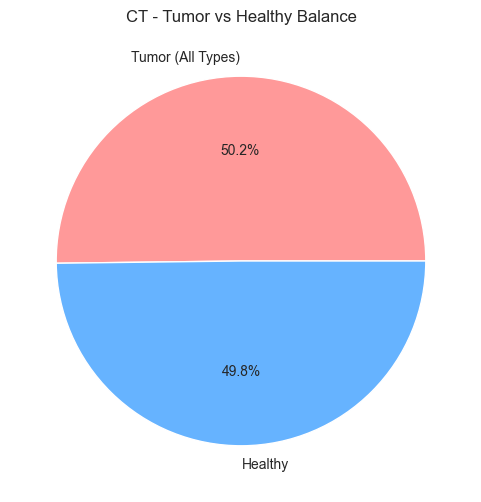


INSPECTING PET DATASET
      Class  Count
     Glioma     17
 Meningioma     16
  Pituitary     20
    Healthy     28
Total Tumor     53
Grand Total     81


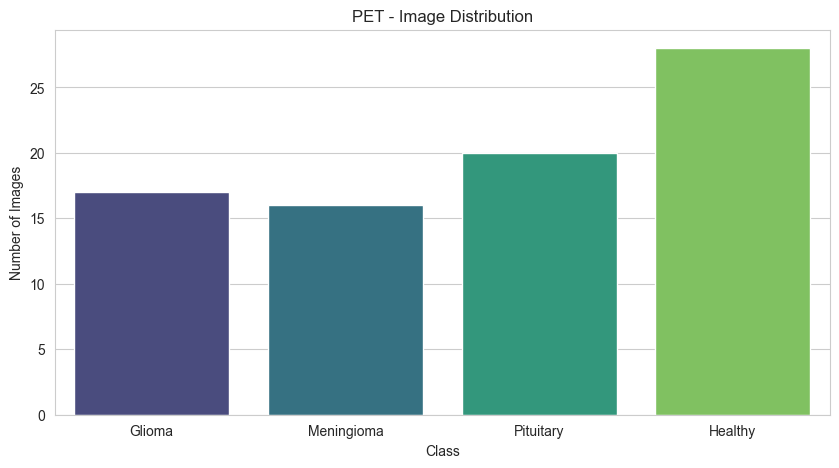

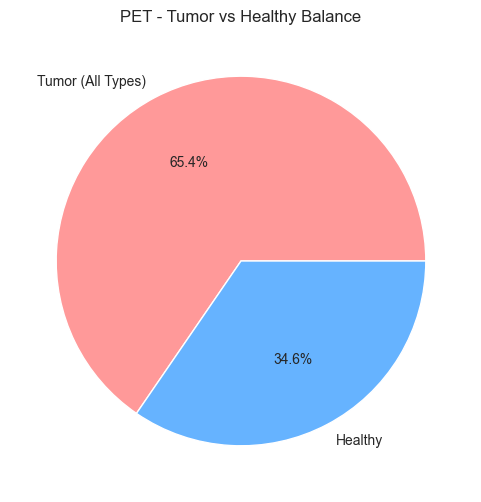

In [6]:
# ==================== PART 2: Comprehensive Inspection ====================
def inspect_modality(modality_name, base_path):
    print(f"\n{'='*60}")
    print(f"INSPECTING {modality_name.upper()} DATASET")
    print(f"{'='*60}")
    
    tumor_base = os.path.join(base_path, 'Tumor')
    healthy_path = os.path.join(base_path, 'Healthy')
    
    subtypes = ['Glioma', 'Meningioma', 'Pituitary']
    
    # Count images
    counts = {}
    total_images = 0
    
    for subtype in subtypes:
        sub_path = os.path.join(tumor_base, subtype)
        if not os.path.exists(sub_path):
            print(f"Warning: {sub_path} NOT FOUND!")
            counts[subtype] = 0
        else:
            files = [f for f in os.listdir(sub_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            counts[subtype] = len(files)
            total_images += len(files)
    
    # Healthy count
    if os.path.exists(healthy_path):
        healthy_files = [f for f in os.listdir(healthy_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        healthy_count = len(healthy_files)
    else:
        healthy_count = 0
        print(f"Warning: Healthy folder not found in {modality_name}")
    
    total_images += healthy_count
    total_tumor = sum(counts.values())
    
    # Store in dataframe
    df = pd.DataFrame({
        'Class': subtypes + ['Healthy'],
        'Count': [counts.get(s, 0) for s in subtypes] + [healthy_count]
    })
    df.loc[len(df)] = ['Total Tumor', total_tumor]
    df.loc[len(df)] = ['Grand Total', total_tumor + healthy_count]
    
    print(df.to_string(index=False))
    
    # Bar plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df.iloc[:-2], x='Class', y='Count', palette='viridis')
    plt.title(f'{modality_name.upper()} - Image Distribution')
    plt.ylabel('Number of Images')
    plt.show()
    
    # Pie chart for binary balance
    binary_labels = ['Tumor (All Types)', 'Healthy']
    binary_counts = [total_tumor, healthy_count]
    plt.figure(figsize=(6, 6))
    plt.pie(binary_counts, labels=binary_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title(f'{modality_name.upper()} - Tumor vs Healthy Balance')
    plt.show()
    
    # Save summary for later
    return {
        'modality': modality_name,
        'details': df,
        'total': total_tumor + healthy_count,
        'tumor': total_tumor,
        'healthy': healthy_count,
        'glioma': counts.get('Glioma', 0),
        'meningioma': counts.get('Meningioma', 0),
        'pituitary': counts.get('Pituitary', 0)
    }

# Run inspection for all three
summary_list = []
for mod in ['mri', 'ct', 'pet']:
    if os.path.exists(mod):
        summary = inspect_modality(mod, mod)
        summary_list.append(summary)
    else:
        print(f"Folder {mod} not found!")

# PART 3: Display Sample Images (Very important for dissertation appendix)

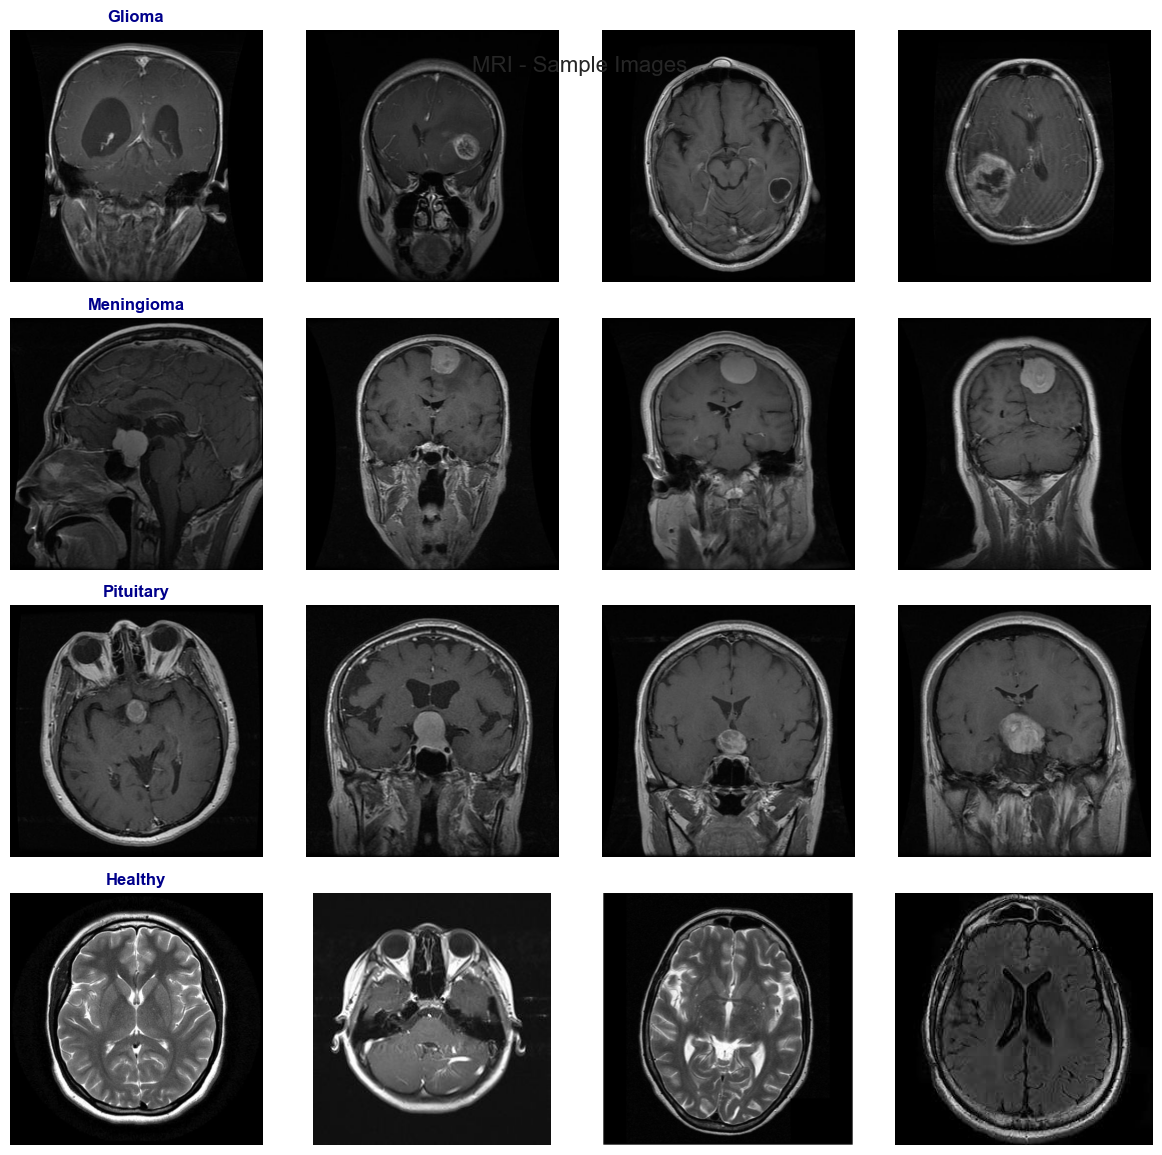

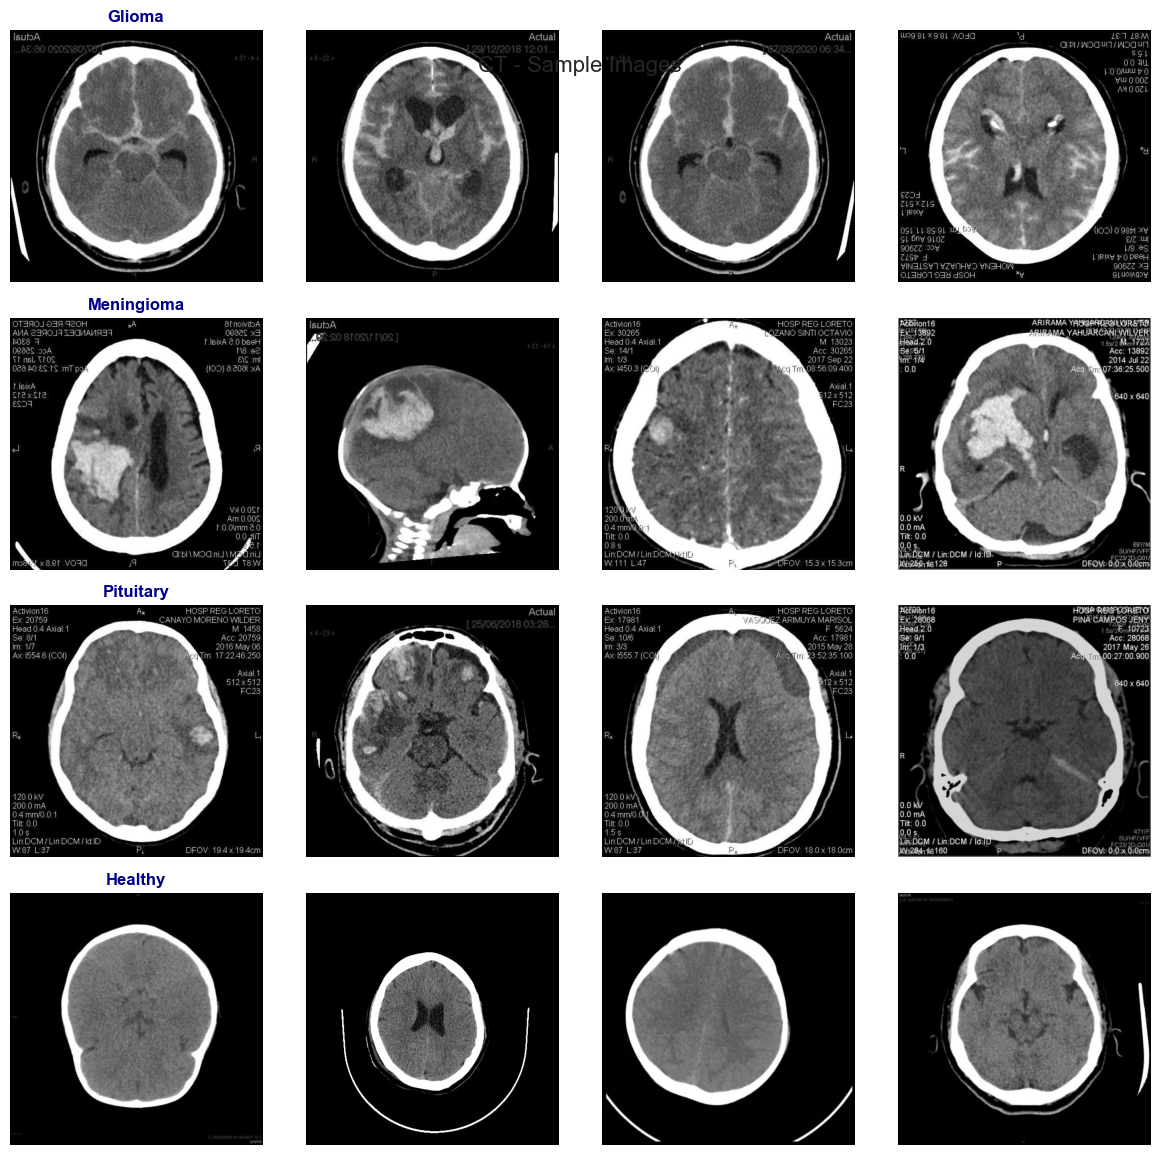

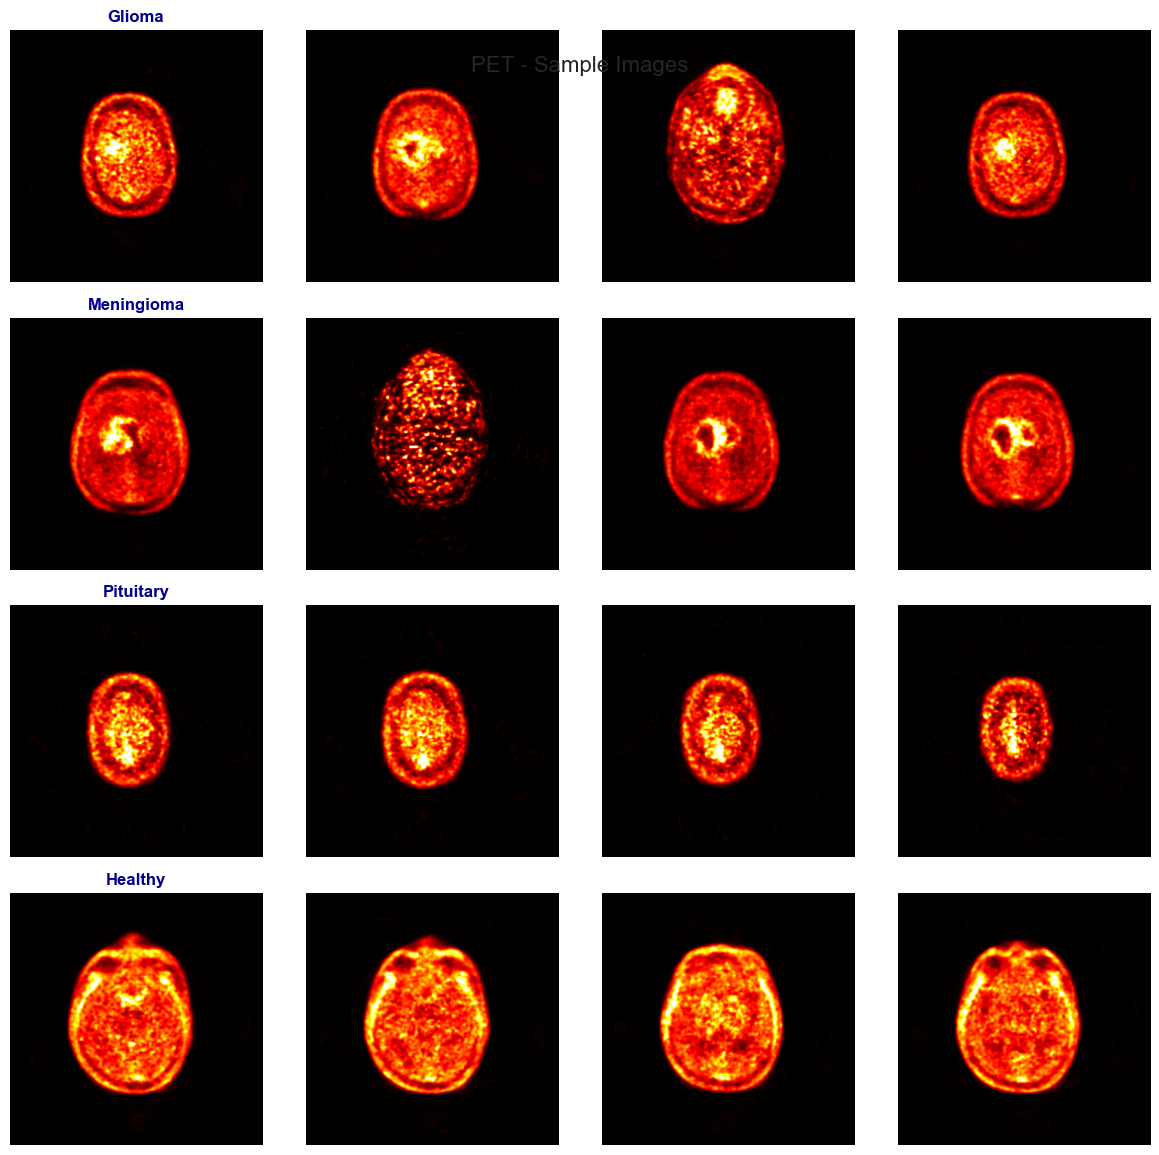

In [8]:
# ==================== PART 3: Show Sample Images ====================
def show_samples(modality_name, base_path, n_per_class=4):
    tumor_base = os.path.join(base_path, 'Tumor')
    healthy_path = os.path.join(base_path, 'Healthy')
    
    fig, axes = plt.subplots(4, n_per_class, figsize=(n_per_class*3, 12))
    fig.suptitle(f"{modality_name.upper()} - Sample Images", fontsize=16, y=0.92)
    
    classes = ['Glioma', 'Meningioma', 'Pituitary', 'Healthy']
    paths = [
        os.path.join(tumor_base, 'Glioma'),
        os.path.join(tumor_base, 'Meningioma'),
        os.path.join(tumor_base, 'Pituitary'),
        healthy_path
    ]
    
    for row, (cls, pth) in enumerate(zip(classes, paths)):
        if not os.path.exists(pth):
            for col in range(n_per_class):
                axes[row, col].text(0.5, 0.5, 'Missing', ha='center', va='center')
                axes[row, col].axis('off')
            continue
            
        files = [f for f in os.listdir(pth) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(files)
        selected = files[:n_per_class]
        
        for col, file in enumerate(selected):
            img_path = os.path.join(pth, file)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                axes[row, col].imshow(img, cmap='gray' if modality_name == 'pet' else None)
                if col == 0:
                    axes[row, col].set_title(cls, fontweight='bold', color='darkblue')
            except Exception as e:
                axes[row, col].text(0.5, 0.5, 'Corrupted', ha='center', va='center', color='red')
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run for all
for mod in ['mri', 'ct', 'pet']:
    if os.path.exists(mod):
        show_samples(mod, mod)

# PART 4: Create Clean Splits (80/10/10) — Modality-Specific Folders

In [9]:
# ==================== PART 4: Create Train/Val/Test Splits ====================
def create_stratified_splits(modality, source_path, split_root="splits"):
    os.makedirs(split_root, exist_ok=True)
    mod_split_path = os.path.join(split_root, modality)
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(mod_split_path, split, 'Tumor', 'Glioma'), exist_ok=True)
        os.makedirs(os.path.join(mod_split_path, split, 'Tumor', 'Meningioma'), exist_ok=True)
        os.makedirs(os.path.join(mod_split_path, split, 'Tumor', 'Pituitary'), exist_ok=True)
        os.makedirs(os.path.join(mod_split_path, split, 'Healthy'), exist_ok=True)
    
    # Collect all paths + labels (for multiclass on tumor only first)
    data = []
    
    # Tumor images (multiclass: 0=Glioma, 1=Meningioma, 2=Pituitary)
    tumor_base = os.path.join(source_path, 'Tumor')
    for label, subtype in enumerate(['Glioma', 'Meningioma', 'Pituitary']):
        sub_path = os.path.join(tumor_base, subtype)
        if os.path.exists(sub_path):
            for f in os.listdir(sub_path):
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    data.append((os.path.join(sub_path, f), label, subtype))
    
    # Healthy images (we'll handle binary separately)
    healthy_path = os.path.join(source_path, 'Healthy')
    if os.path.exists(healthy_path):
        for f in os.listdir(healthy_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                data.append((os.path.join(healthy_path, f), 3, 'Healthy'))  # 3 = Healthy
    
    if len(data) == 0:
        print(f"No data found for {modality}")
        return
    
    paths, labels, class_names = zip(*data)
    
    # First split off test set
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        paths, labels, test_size=0.10, stratify=labels, random_state=42
    )
    
    # Then split remaining into train/val
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=0.1111, stratify=train_val_labels, random_state=42
        # 0.1111 of 90% → ~10% of original
    )
    
    # Copy function
    def copy_files(file_list, label_list, split_name):
        for src, lbl in zip(file_list, label_list):
            if lbl == 0: dest_sub = 'Glioma'
            elif lbl == 1: dest_sub = 'Meningioma'
            elif lbl == 2: dest_sub = 'Pituitary'
            else: dest_sub = 'Healthy'; dest_folder = os.path.join(mod_split_path, split_name, 'Healthy')
            
            if lbl < 3:
                dest_folder = os.path.join(mod_split_path, split_name, 'Tumor', dest_sub)
            
            shutil.copy(src, os.path.join(dest_folder, os.path.basename(src)))
    
    copy_files(train_paths, train_labels, 'train')
    copy_files(val_paths, val_labels, 'val')
    copy_files(test_paths, test_labels, 'test')
    
    print(f"{modality.upper()} splits created:")
    print(f"   Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# Create splits for all modalities
for mod in ['mri', 'ct', 'pet']:
    if os.path.exists(mod):
        create_stratified_splits(mod, mod)

MRI splits created:
   Train: 3529 | Val: 442 | Test: 442
CT splits created:
   Train: 3694 | Val: 462 | Test: 462
PET splits created:
   Train: 64 | Val: 8 | Test: 9


# PART 5: Final Summary Table (Perfect for Dissertation)

In [10]:
# ==================== PART 5: Final Summary Table ====================
final_summary = pd.DataFrame([
    {
        'Modality': s['modality'].upper(),
        'Glioma': s['glioma'],
        'Meningioma': s['meningioma'],
        'Pituitary': s['pituitary'],
        'Healthy': s['healthy'],
        'Total Tumor': s['tumor'],
        'Grand Total': s['total']
    } for s in summary_list
])
print("\nFINAL DATASET SUMMARY")
print(final_summary.to_string(index=False))

# Save to CSV for thesis
final_summary.to_csv("dataset_summary_step1.csv", index=False)
print("\nSummary saved as 'dataset_summary_step1.csv'")


FINAL DATASET SUMMARY
Modality  Glioma  Meningioma  Pituitary  Healthy  Total Tumor  Grand Total
     MRI     672        1112        629     2000         2413         4413
      CT      68        2157         93     2300         2318         4618
     PET      17          16         20       28           53           81

Summary saved as 'dataset_summary_step1.csv'
